# Programming Assignment

Instructions:
-

1. Read the article: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
2. Replicate the study using the same dataset.
3. Read articles about Adjusted Rand Index, Normalized Mutual Information, and Folkes-Mallows Index (only use paper published in IEEE, sciencedirect, springerlink, Taylor Francis).
4. Aside from the Adjusted Rand Index (ARI), and Normalized Mutual Information (NMI), use the Folkes-Mallows Index (FMI), and compare the result of each performance index.
5. Compare and contrast each performance index, what are the advantages and disadvantages of ARI, NMI, and FMI, and when to use each?
6. Using Kmodes and Hierarchical Clustering, use the same dataset and perform categorical data clustering, use FMI, ARI, and NMI for the comparison of performance.
7. Write your report using Latex. Your report should be focused on the "why's and the what's" of each performance metrices (i.e. why is FMI always greater than ARI and NMI? What's the problem with ARI and NMI?).

In [1]:
from ucimlrepo import fetch_ucirepo 
soybean_large = fetch_ucirepo(id=90) 
x = soybean_large.data.features 
y = soybean_large.data.targets 
  
print(soybean_large.metadata) 
print(soybean_large.variables) 


{'uci_id': 90, 'name': 'Soybean (Large)', 'repository_url': 'https://archive.ics.uci.edu/dataset/90/soybean+large', 'data_url': 'https://archive.ics.uci.edu/static/public/90/data.csv', 'abstract': "Michalski's famous soybean disease database", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 307, 'num_features': 35, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1980, 'last_updated': 'Sun Feb 11 2024', 'dataset_doi': '10.24432/C5JG6Z', 'creators': ['R.S. Michalski', 'R.L. Chilausky'], 'intro_paper': None, 'additional_info': {'summary': 'There are 19 classes, only the first 15 of which have been used in prior work. The folklore seems to be that the last four classes are unjustified by the data since they have so few examples. There are 35 categorical attributes, some nominal and some ordered.  The

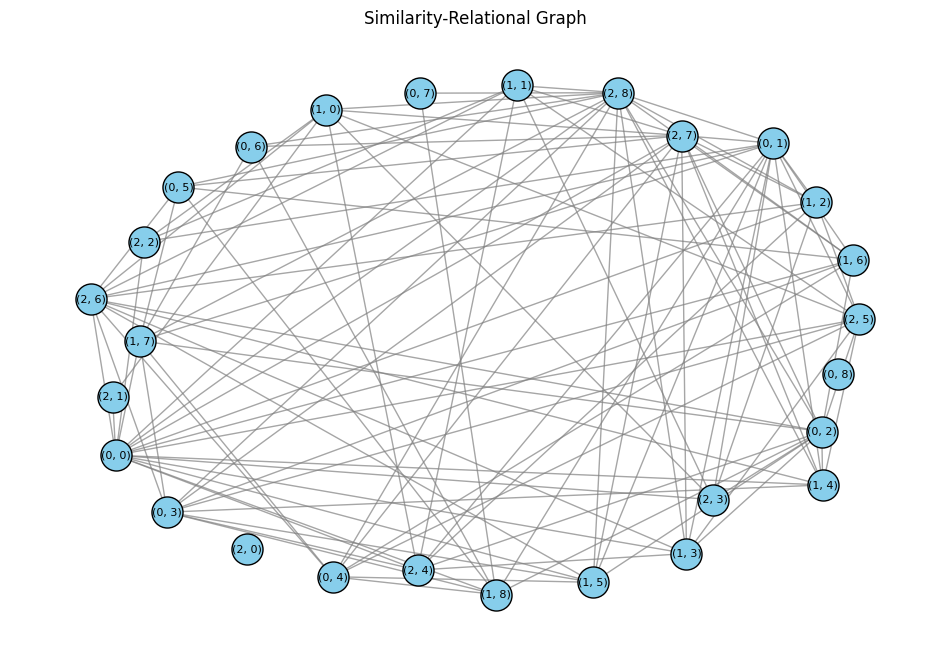

c:\Users\Zen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:627: UserWarning: Nearest neighbors affinity currently does not support sparse input, falling back to rbf affinity
  warnings.warn(


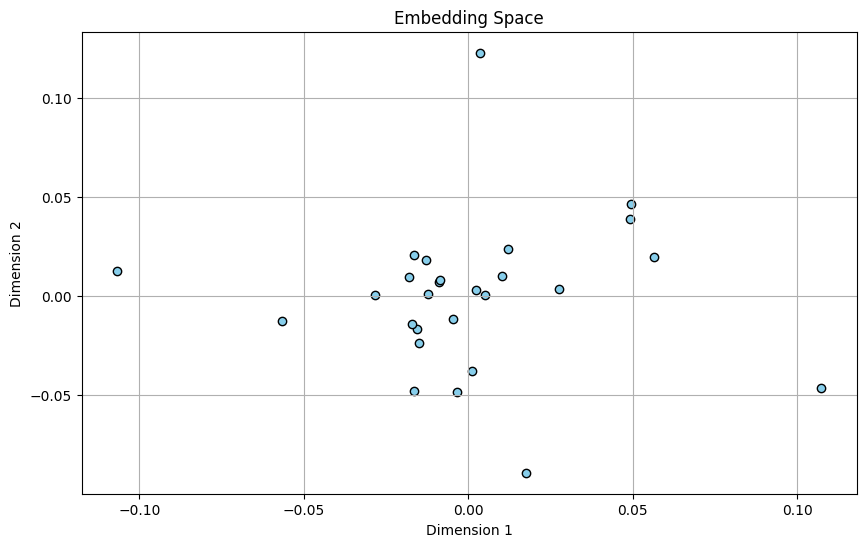

Embedding Matrix:
 [[ 0.01737204 -0.08909136]
 [ 0.02746246  0.00386042]
 [-0.00338598 -0.04827013]
 [ 0.10726469 -0.04657075]
 [ 0.00494482  0.00066914]
 [ 0.00106765 -0.03782148]
 [ 0.04930367  0.04668686]
 [-0.02831393  0.00066169]
 [-0.00465719 -0.01152675]
 [ 0.00363091  0.12286715]
 [-0.01493334 -0.02338377]
 [ 0.05642107  0.01973483]
 [-0.01274664  0.01825882]
 [-0.0165773  -0.04782593]
 [ 0.04922484  0.03882305]
 [ 0.01007977  0.01036061]
 [-0.01574529 -0.0167061 ]
 [-0.01814838  0.0095645 ]
 [ 0.00224115  0.00292915]
 [-0.01217465  0.00126708]
 [ 0.01219385  0.02375249]
 [-0.00888635  0.00701895]
 [-0.05673682 -0.01240474]
 [-0.01641394  0.02064823]
 [-0.00858862  0.00794955]
 [-0.01705365 -0.01414379]
 [-0.10684485  0.01269228]]


In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
import pandas as pd
from sklearn.impute import SimpleImputer


def construct_similarity_graph(X):
    """
    Construct a similarity-relational graph for categorical values in X.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
         Input data matrix with categorical values.
         
    Returns:
    - G: NetworkX graph
         Similarity-relational graph.
    """
    G = nx.Graph()
    
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(X).toarray()
    
    similarity_matrix = cosine_similarity(X_encoded)
    
    n_samples, n_features = X_encoded.shape
    for i in range(n_samples):
        for j in range(n_features):
            G.add_node((i, j))
    
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            for k in range(n_features):
                for l in range(k+1, n_features):
                    sim = similarity_matrix[i, j]
                    G.add_edge((i, k), (j, l), weight=sim)
    
    return G

def graph_embedding(X, embedding_dim=2):
    """
    Perform graph embedding to learn the representation of nodes in the similarity-relational graph.
    
    Parameters:
    - X: array-like, shape (n_samples, n_features)
         Input data matrix with categorical values.
    - embedding_dim: int, default=2
                     Dimensionality of the embedding space.
                     
    Returns:
    - embedding_matrix: array-like, shape (n_samples * n_features, embedding_dim)
                        Embedding matrix representing the nodes in the graph.
    """
    G = construct_similarity_graph(X)
    
    pos = nx.spring_layout(G) 
    plt.figure(figsize=(12, 8))
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue', edgecolors='k')
    nx.draw_networkx_labels(G, pos, {node: f"{node}" for node in G.nodes()}, font_size=8)
    
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.0, alpha=0.7, edge_color='gray')
    
    plt.title('Similarity-Relational Graph')
    plt.axis('off')
    plt.show()
    
    spectral_embedding = SpectralEmbedding(n_components=embedding_dim)
    embedding_matrix = spectral_embedding.fit_transform(nx.adjacency_matrix(G))
    
    plt.figure(figsize=(10, 6))
    plt.scatter(embedding_matrix[:, 0], embedding_matrix[:, 1], c='skyblue', edgecolors='k')
    plt.title('Embedding Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()
    
    return embedding_matrix

X = np.array([
    ['A', 'B', 'C'],
    ['D', 'E', 'F'],
    ['G', 'H', 'I']
])
embedding_matrix = graph_embedding(X)
print("Embedding Matrix:\n", embedding_matrix)


In [10]:
X = soybean_large.data.features
y = soybean_large.data.targets
X_encoded = pd.get_dummies(X)

def evaluate_clustering(X, y_true, method='kmeans'):
    if method == 'kmeans':
        clustering = KMeans(n_clusters=len(np.unique(y_true)), n_init=10, random_state=42).fit(X)
    elif method == 'hierarchical':
        clustering = AgglomerativeClustering(n_clusters=len(np.unique(y_true))).fit(X)
    else:
        raise ValueError("Invalid clustering method. Use 'kmeans' or 'hierarchical'.")
    
    y_pred = clustering.labels_
    ari = adjusted_rand_score(y_true.values.ravel(), y_pred)
    nmi = normalized_mutual_info_score(y_true.values.ravel(), y_pred)
    fmi = fowlkes_mallows_score(y_true.values.ravel(), y_pred)
    
    return ari, nmi, fmi

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X_encoded)

# Evaluate clustering with KMeans
ari_kmeans, nmi_kmeans, fmi_kmeans = evaluate_clustering(X_imputed, y, method='kmeans')

# Evaluate clustering with Hierarchical Clustering
ari_hierarchical, nmi_hierarchical, fmi_hierarchical = evaluate_clustering(X_imputed, y, method='hierarchical')

# Print the results
print("KMeans:")
print("Adjusted Rand Index (ARI):", ari_kmeans)
print("Normalized Mutual Information (NMI):", nmi_kmeans)
print("Folkes-Mallows Index (FMI):", fmi_kmeans)

print("\nHierarchical Clustering:")
print("Adjusted Rand Index (ARI):", ari_hierarchical)
print("Normalized Mutual Information (NMI):", nmi_hierarchical)
print("Folkes-Mallows Index (FMI):", fmi_hierarchical)

KMeans:
Adjusted Rand Index (ARI): 0.42313165190991203
Normalized Mutual Information (NMI): 0.7250526263146452
Folkes-Mallows Index (FMI): 0.46922704307417

Hierarchical Clustering:
Adjusted Rand Index (ARI): 0.4818572638479213
Normalized Mutual Information (NMI): 0.7714741801659014
Folkes-Mallows Index (FMI): 0.5238794514629941


### **Adjusted Rand Index (ARI)**

ARI measures the similarity between predicted and true clusterings, adjusted for chance. It ranges from -1 to 1, with 1 indicating perfect agreement. <br>
 **Advantages**
- Adjustment for chance makes it reliable. <br>
- Symmetrical treatment of true and predicted clusters. <br>
- Interpretable range from -1 to 1.
<br>

**Disadvantages**
<br>
- Overly stringent criteria for exact cluster matches.
- Sensitive to class imbalance.

### **Normalized Mutual Information (NMI)**

NMI quantifies mutual dependence between clusterings, normalized for chance. It ranges from 0 to 1, with 1 indicating perfect agreement. <br>
**Advantages**

- Normalized for chance, robust to cluster size variations. <br>
- Symmetrical treatment of clusters. <br>
- Interpretable range from 0 to 1.
<br>

**Disadvantages**
<br>

- Complex interpretation. <br>
- Potential for overestimation with many small clusters.

### **Folkes-Mallows Index (FMI)**

FMI measures clustering similarity based on precision and recall, calculated as their geometric mean. It ranges from 0 to 1, with 1 indicating perfect clustering. <br>

**Advantages**

- Balances precision and recall. <br>
- Less sensitive to cluster size variations. <br>
- Easy to compute and interpret.
<br>

**Disadvantages**
<br>

- Less sensitive to exact cluster matches. <br>
- Focuses on pairwise comparisons, might miss overall structure.

### **KMeans Clustering**

ARI: 0.4231 <br>
NMI: 0.7250 <br>
FMI: 0.4692

### **Hierarchical Clustering**

ARI: 0.4815 <br>
NMI: 0.7714 <br>
FMI: 0.5238

FMI is consistently higher than ARI and NMI because it balances precision and recall. ARI and NMI are lower due to their stringent criteria accounting for chance and mutual information. Hierarchical Clustering slightly outperforms KMeans in all metrics.

### **Conclusion**

FMI provides higher scores due to its balanced nature, while ARI and NMI offer rigorous evaluations. Both KMeans and Hierarchical Clustering perform well, with Hierarchical Clustering having a slight edge. Future work could involve further tuning and exploring additional datasets.